# SWB Regression Pipeline - Gamma Power 
Created: 07/30/24 \
Updated: 09/25/2024 \
*updated with 1sec regression dfs*

In [1]:
import numpy as np
import mne
from glob import glob
import matplotlib.pyplot as plt
from matplotlib.backends.backend_pdf import PdfPages
import seaborn as sns
from scipy.stats import zscore, linregress, ttest_ind, ttest_rel, ttest_1samp, pearsonr, spearmanr
import pandas as pd
from mne.preprocessing.bads import _find_outliers
import os 
import joblib
import re
import datetime
import scipy
import random
import statsmodels.api as sm
import statsmodels.formula.api as smf
from statsmodels.stats.outliers_influence import variance_inflation_factor
from statsmodels.regression.mixed_linear_model import MixedLM 
from joblib import Parallel, delayed
import pickle
import itertools
import time 
from matplotlib.ticker import StrMethodFormatter
from matplotlib.colors import ListedColormap,LinearSegmentedColormap
import matplotlib as mpl
from matplotlib import cm
import patsy
from statsmodels.api import OLS
from scipy import stats
from tqdm import tqdm
# from sklearn.linear_model import RANSACRegressor
# from sklearn.metrics import r2_score, mean_squared_error



import warnings
warnings.filterwarnings('ignore')




In [2]:
%load_ext autoreload
%autoreload 2

In [3]:
# Specify root directory for un-archived data and results 
base_dir   = '/sc/arion/projects/guLab/Alie/SWB/'
anat_dir   = f'{base_dir}ephys_analysis/recon_labels/'
neural_dir = f'{base_dir}ephys_analysis/data/'
behav_dir  = f'{base_dir}swb_behav_models/data/behavior_preprocessed/'
save_dir   = f'{base_dir}ephys_analysis/results/regression_data/'
fig_dir    = f'{base_dir}ephys_analysis/figs/regression_figs/'
script_dir = '/hpc/users/finka03/swb_ephys_analysis/scripts/'

date = datetime.date.today().strftime('%m%d%Y')
print(date)

09252024


In [4]:
import sys
sys.path.append(f'{base_dir}ephys_analysis/LFPAnalysis/')

from LFPAnalysis import analysis_utils

sys.path.append(f'{script_dir}analysis_notebooks/')

from ieeg_tools import *
from plot_tools import *

In [5]:
subj_ids = list(pd.read_excel(f'{base_dir}ephys_analysis/subj_info/SWB_subjects.xlsx', sheet_name='Usable_Subjects', usecols=[0]).PatientID)
n_subj = len(subj_ids)
# subj_ids


In [6]:
bdi_list = pd.read_excel(f'{base_dir}ephys_analysis/subj_info/SWB_subjects.xlsx', sheet_name='Usable_Subjects', usecols=[3])
bdi_list = list(bdi_list.SWB_BDI)
subj_info_df = pd.DataFrame({'subj_id':subj_ids,'bdi':bdi_list})
subj_info_df



,subj_id,bdi
0,MS002,14
1,MS003,8
2,MS009,16
3,MS011,13
4,MS015,26
5,MS016,10
6,MS017,26
7,MS019,12
8,MS022,10
9,MS024,16


# Load beta power data 

In [7]:
epoch_len = '1sec'

In [8]:
band = 'gamma'
gamma_df = pd.read_csv(f'{save_dir}{band}_master_df_{epoch_len}.csv')
gamma_df.subj_id.unique()

array(['MS002', 'MS003', 'MS009', 'MS011', 'MS015', 'MS016', 'MS017',
       'MS019', 'MS022', 'MS024', 'MS025', 'MS026', 'MS027', 'MS028',
       'MS029', 'MS030', 'MS033', 'MS035', 'MS041', 'MS043', 'MS048',
       'MS050', 'DA8', 'DA023', 'DA026', 'DA037', 'DA039'], dtype=object)

In [9]:
roi_reref_labels_master_df = pd.read_csv(glob(f'{base_dir}ephys_analysis/results/roi_info/roi_reref_labels_master.csv')[0])
roi_reref_labels_master_df = roi_reref_labels_master_df.drop(columns=['Unnamed: 0'])




In [10]:
roi_reref_labels_master_df.roi.value_counts()

roi
dmpfc            225
ofc              202
acc              193
sts              155
hpc              135
amy              113
dlpfc            107
temporal         105
vlpfc             82
ains              71
pins              60
thalamus          58
temporal pole     31
mcc               28
phg               25
motor             25
parietal          24
vmpfc             23
caudate            8
pcc                1
Name: count, dtype: int64

In [11]:
# #### filter df by rois with electrode counts >= 50 *** updated to >15
# keep_rois = roi_reref_labels_master_df.roi.value_counts().index[roi_reref_labels_master_df.roi.value_counts(
# ).values>=20].tolist()

keep_rois = ['dlpfc','vlpfc','dmpfc','ofc','ains','pins','acc','amy','hpc']     

keep_rois


['dlpfc', 'vlpfc', 'dmpfc', 'ofc', 'ains', 'pins', 'acc', 'amy', 'hpc']

In [12]:
# ####### NEW DATA FRAME 
gamma_reg_df = gamma_df.copy()
gamma_reg_df = gamma_reg_df[gamma_reg_df.roi.isin(keep_rois)]

# Test Single Electrode Regressions 

In [14]:
elec_col    = 'unique_reref_ch'
main_var    = 'cpe'
reg_formula = 'band_pow~GambleChoice+TotalProfit+cpe'
# n_permutations = 1000
# results_dict, main_var_sig = run_individual_elec_regression(gamma_reg_df,reg_formula,
#                                                             elec_col, main_var,n_permutations)



In [17]:
results = pickle.load(open(f'{save_dir}single_elec_regression_gamma_band_pow~GambleChoice+TotalProfit+cpe_1sec_09252024.pkl',"rb"))


In [20]:
# save_vars = results_dict['MS002_lacas1-lacas2'].index.tolist()
# save_vars


['Intercept', 'GambleChoice[T.safe]', 'TotalProfit', 'cpe']

In [21]:
# results = single_elec_permutation_results(results_dict,gamma_reg_df,save_vars)
# results



,unique_elec_id,subj_id,roi,bdi,Original_Estimate_Intercept,Original_Estimate_GambleChoice[T.safe],Original_Estimate_TotalProfit,Original_Estimate_cpe,Permuted_Mean_Intercept,Permuted_Mean_GambleChoice[T.safe],...,Permuted_Std_TotalProfit,Permuted_Std_cpe,Z_Score_Intercept,Z_Score_GambleChoice[T.safe],Z_Score_TotalProfit,Z_Score_cpe,P_Value_Intercept,P_Value_GambleChoice[T.safe],P_Value_TotalProfit,P_Value_cpe
0,MS002_lacas1-lacas2,MS002,acc,14,0.023059,-0.058982,-0.027413,0.046150,-0.017886,-0.000434,...,0.026425,0.027036,2.072474,-2.054294,-0.973628,1.725688,0.038221,0.039947,0.330241,0.084404
1,MS002_lacas2-lacas3,MS002,acc,14,0.031858,-0.059549,-0.023417,0.027134,-0.010473,0.001129,...,0.029668,0.028070,1.908253,-1.897345,-0.815133,1.006457,0.056359,0.057782,0.414996,0.314196
2,MS002_lacas3-lacas4,MS002,acc,14,0.001446,0.006873,-0.005621,-0.025320,0.006463,-0.000227,...,0.027364,0.027897,-0.240104,0.235689,-0.199962,-0.880840,0.810249,0.813674,0.841510,0.378404
3,MS002_lacas4-lacas5,MS002,acc,14,0.003229,-0.009011,-0.002791,0.051790,-0.002170,-0.001589,...,0.024507,0.024295,0.287233,-0.273950,-0.101503,2.133686,0.773934,0.784123,0.919151,0.032868
4,MS002_lacas5-lacas6,MS002,acc,14,0.055839,-0.066829,-0.014107,0.030358,0.009251,0.000027,...,0.024179,0.023136,2.601209,-2.589236,-0.551797,1.347850,0.009290,0.009619,0.581088,0.177707
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1183,DA039_rpins1-rpins2,DA039,pins,22,-0.020003,0.038866,-0.004627,-0.054108,-0.005147,0.000116,...,0.030591,0.028502,-1.257967,1.308381,-0.184305,-1.847709,0.208404,0.190744,0.853774,0.064644
1184,DA039_rpins2-rpins3,DA039,pins,22,0.021258,-0.020760,0.000949,-0.015194,0.012087,0.001729,...,0.034308,0.033193,0.667049,-0.652074,0.037935,-0.422669,0.504741,0.514354,0.969739,0.672536
1185,DA039_rpins3-rpins4,DA039,pins,22,-0.036366,-0.015772,0.020380,-0.056338,-0.044539,0.001857,...,0.039462,0.036560,0.519991,-0.446910,0.549771,-1.526725,0.603070,0.654940,0.582477,0.126829
1186,DA039_rsgcc6-rsgcc7,DA039,vlpfc,22,-0.006123,-0.006062,0.005151,0.017276,-0.008418,0.000088,...,0.024409,0.023851,0.230165,-0.245342,0.156473,0.730779,0.817963,0.806192,0.875660,0.464914


In [23]:
# # # create a binary pickle file 
# pickle.dump(results,
#             open(f'{save_dir}single_elec_regression_{band}_{reg_formula}_{epoch_len}_{date}.pkl',"wb"))




In [19]:
results.head()

,unique_elec_id,subj_id,roi,bdi,Original_Estimate_Intercept,Original_Estimate_GambleChoice[T.safe],Original_Estimate_TotalProfit,Original_Estimate_cpe,Permuted_Mean_Intercept,Permuted_Mean_GambleChoice[T.safe],...,Permuted_Std_TotalProfit,Permuted_Std_cpe,Z_Score_Intercept,Z_Score_GambleChoice[T.safe],Z_Score_TotalProfit,Z_Score_cpe,P_Value_Intercept,P_Value_GambleChoice[T.safe],P_Value_TotalProfit,P_Value_cpe
0,MS002_lacas1-lacas2,MS002,acc,14,0.023059,-0.058982,-0.027413,0.046150,-0.017886,-0.000434,...,0.026425,0.027036,2.072474,-2.054294,-0.973628,1.725688,0.038221,0.039947,0.330241,0.084404
1,MS002_lacas2-lacas3,MS002,acc,14,0.031858,-0.059549,-0.023417,0.027134,-0.010473,0.001129,...,0.029668,0.028070,1.908253,-1.897345,-0.815133,1.006457,0.056359,0.057782,0.414996,0.314196
2,MS002_lacas3-lacas4,MS002,acc,14,0.001446,0.006873,-0.005621,-0.025320,0.006463,-0.000227,...,0.027364,0.027897,-0.240104,0.235689,-0.199962,-0.880840,0.810249,0.813674,0.841510,0.378404
3,MS002_lacas4-lacas5,MS002,acc,14,0.003229,-0.009011,-0.002791,0.051790,-0.002170,-0.001589,...,0.024507,0.024295,0.287233,-0.273950,-0.101503,2.133686,0.773934,0.784123,0.919151,0.032868
4,MS002_lacas5-lacas6,MS002,acc,14,0.055839,-0.066829,-0.014107,0.030358,0.009251,0.000027,...,0.024179,0.023136,2.601209,-2.589236,-0.551797,1.347850,0.009290,0.009619,0.581088,0.177707


In [20]:
sig_data = results[results['P_Value_cpe']<0.05]
sig_data



,unique_elec_id,subj_id,roi,bdi,Original_Estimate_Intercept,Original_Estimate_GambleChoice[T.safe],Original_Estimate_TotalProfit,Original_Estimate_cpe,Permuted_Mean_Intercept,Permuted_Mean_GambleChoice[T.safe],...,Permuted_Std_TotalProfit,Permuted_Std_cpe,Z_Score_Intercept,Z_Score_GambleChoice[T.safe],Z_Score_TotalProfit,Z_Score_cpe,P_Value_Intercept,P_Value_GambleChoice[T.safe],P_Value_TotalProfit,P_Value_cpe
3,MS002_lacas4-lacas5,MS002,acc,14,0.003229,-0.009011,-0.002791,0.051790,-0.002170,-0.001589,...,0.024507,0.024295,0.287233,-0.273950,-0.101503,2.133686,0.773934,0.784123,0.919151,0.032868
14,MS002_laims3-laims4,MS002,ains,14,0.092269,-0.043521,-0.000187,-0.080951,0.061679,0.001100,...,0.033072,0.033698,1.246533,-1.261775,0.007311,-2.388051,0.212569,0.207030,0.994167,0.016938
19,MS002_laims11-laims12,MS002,dmpfc,14,-0.067734,0.027565,-0.019455,0.056214,-0.050040,0.001577,...,0.025231,0.024145,-0.877463,0.894191,-0.790699,2.315825,0.380235,0.371220,0.429119,0.020568
48,MS002_racas1-racas2,MS002,acc,14,0.036716,-0.053661,-0.018756,0.079931,-0.001442,0.000693,...,0.027987,0.027182,1.861212,-1.838898,-0.617301,2.972704,0.062714,0.065930,0.537036,0.002952
60,MS002_raims3-raims4,MS002,ains,14,0.193927,-0.137152,-0.043576,0.104729,0.096445,0.002372,...,0.037502,0.036546,3.436013,-3.411869,-1.211244,2.884913,0.000590,0.000645,0.225802,0.003915
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1176,DA039_rof5-rof6,DA039,ofc,22,-0.003600,-0.030462,-0.004761,0.041959,-0.015047,-0.000141,...,0.011345,0.011319,2.448372,-2.582811,-0.386251,3.713601,0.014350,0.009800,0.699311,0.000204
1178,DA039_rof7-rof8,DA039,vlpfc,22,-0.006491,-0.053423,-0.008988,0.070018,-0.026684,-0.000065,...,0.025642,0.026085,1.950250,-2.048389,-0.295747,2.694146,0.051146,0.040522,0.767423,0.007057
1180,DA039_rof9-rof10,DA039,dlpfc,22,-0.029175,0.010883,-0.036693,0.048051,-0.023816,0.000783,...,0.024388,0.024152,-0.528784,0.397868,-1.498117,2.005017,0.596955,0.690727,0.134103,0.044961
1181,DA039_rof10-rof11,DA039,dlpfc,22,-0.024173,-0.012521,0.013557,0.061380,-0.028413,-0.000505,...,0.024804,0.025190,0.392907,-0.443847,0.531840,2.413300,0.694388,0.657153,0.594837,0.015809


In [21]:
sig_data.roi.value_counts()



roi
ofc      43
acc      27
ains     20
dmpfc    20
dlpfc    14
amy      13
vlpfc     9
hpc       6
pins      2
Name: count, dtype: int64

In [22]:
sig_data.roi.unique()



array(['acc', 'ains', 'dmpfc', 'hpc', 'amy', 'vlpfc', 'ofc', 'dlpfc',
       'pins'], dtype=object)

In [23]:
# bar_order = ['dlpfc','vlpfc','dmpfc','ofc','ains','pins', 'acc','hpc','amy']
bar_order = keep_rois.copy()

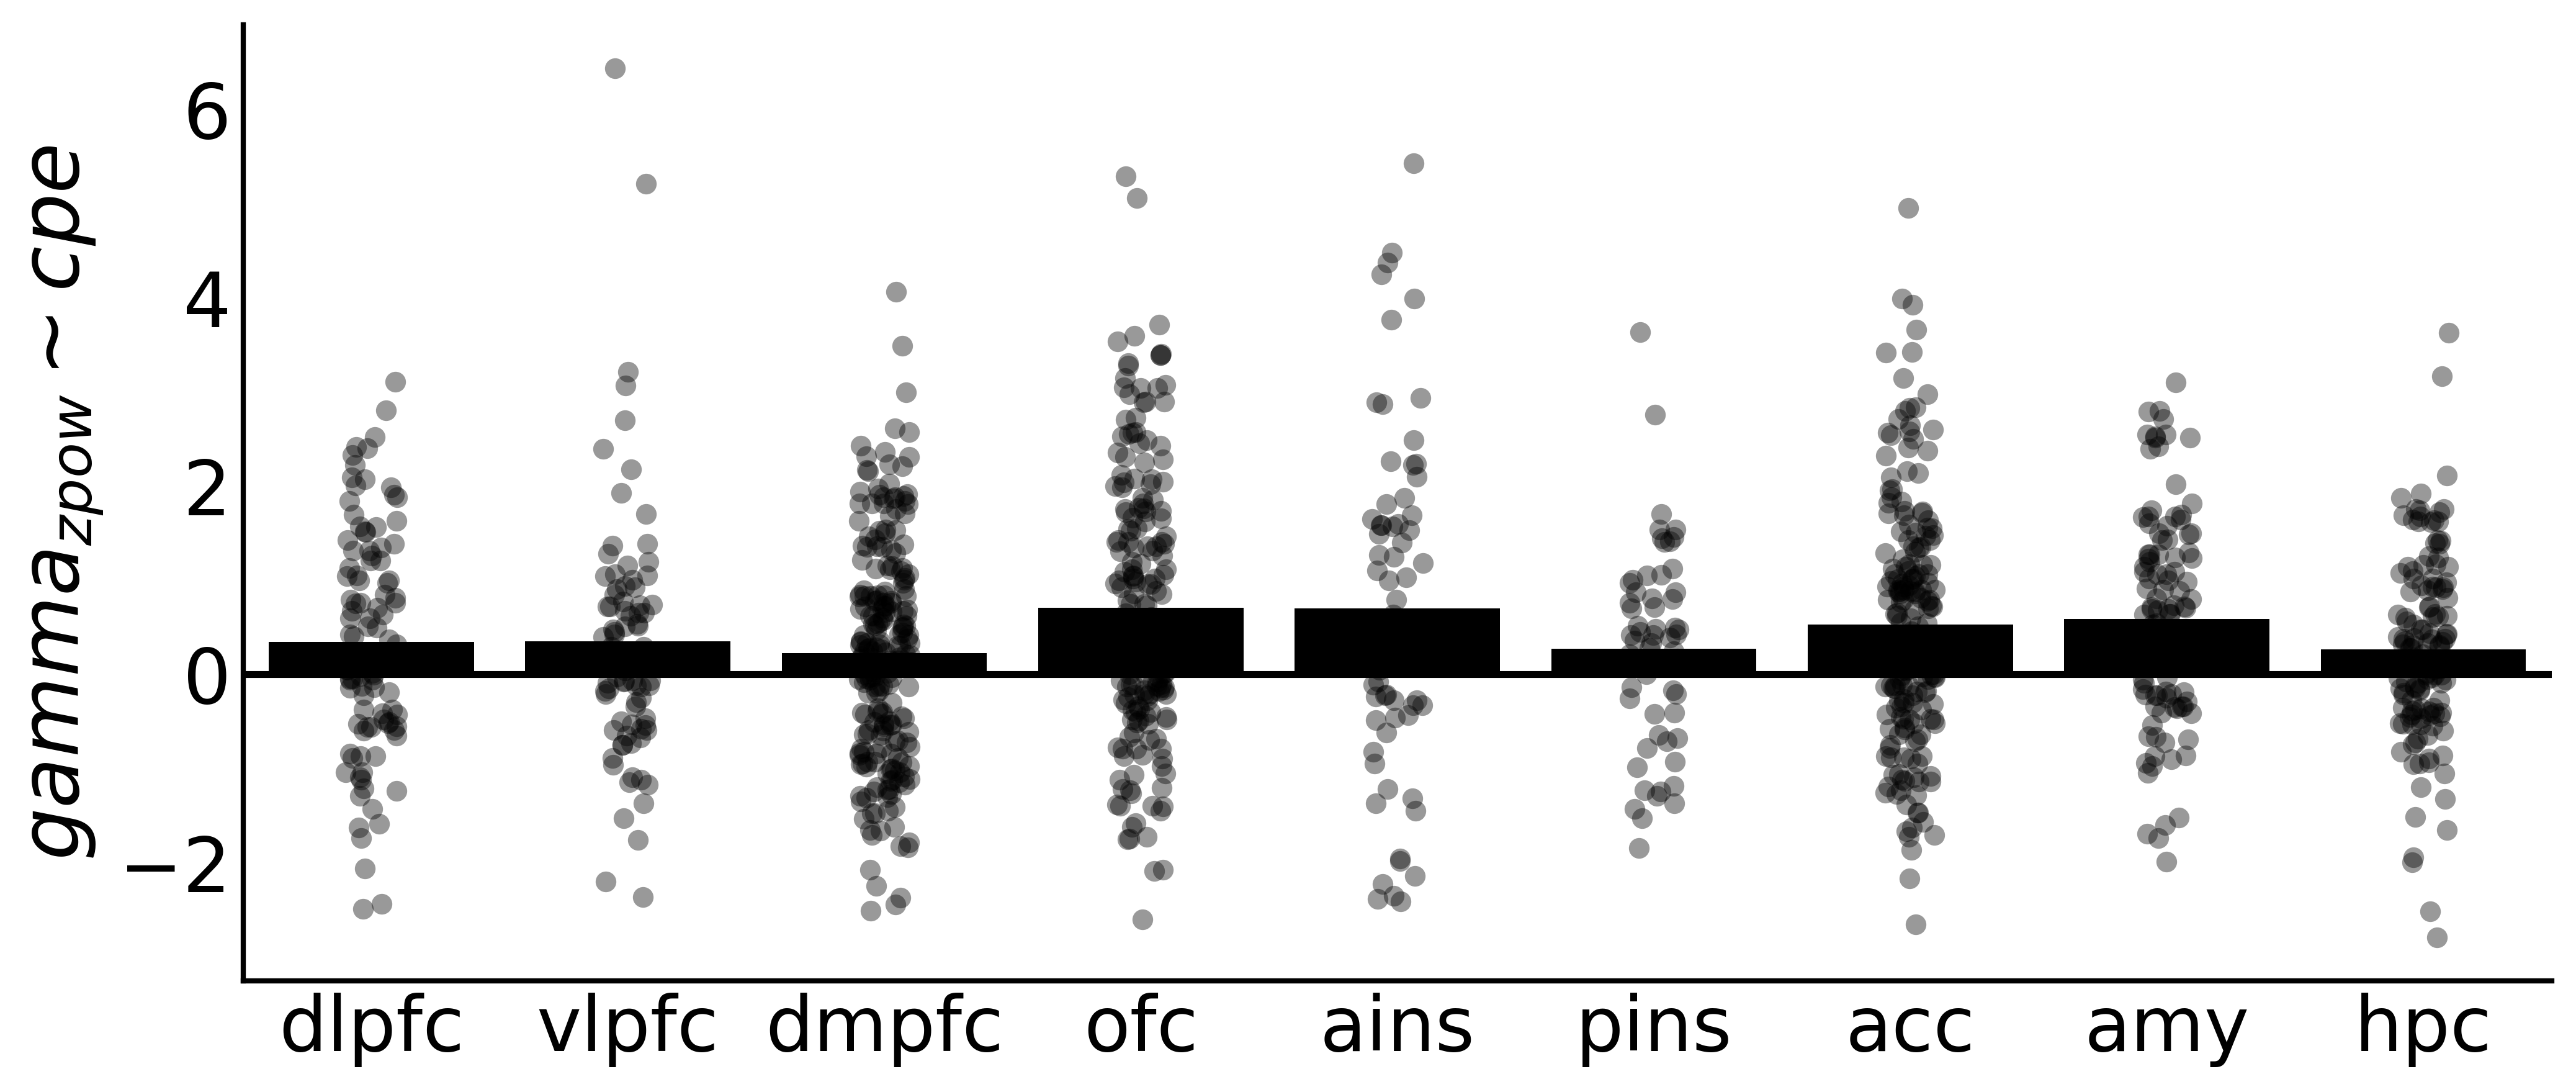

In [24]:
ylabel = fr'${band}_{{zpow}} \sim cpe$'
# fig_save_dir = '/sc/arion/projects/guLab/Alie/SWB/ephys_analysis/results/single-electrode-regressions/'
fig_id = f'{band}_single_elec_roi_barplot_{epoch_len}.pdf'


plot_roi_model_results(results,'roi','Z_Score_cpe',bar_order=keep_rois,figsize=(12,5),color='k',
                       ylabel=ylabel,save_fig=True,save_dir=fig_dir,fig_id=fig_id,dpi=400)



In [32]:
# results.to_csv(f'{save_dir}{band}_single_elec_perm_results_{epoch_len}.csv')

In [25]:
results.groupby('roi').agg('mean',numeric_only=True)['Z_Score_cpe'][bar_order]



roi
dlpfc    0.342544
vlpfc    0.346689
dmpfc    0.221718
ofc      0.706971
ains     0.699671
pins     0.268073
acc      0.526780
amy      0.589415
hpc      0.263261
Name: Z_Score_cpe, dtype: float64

In [26]:
single_elec_res = results.copy()[results.roi.isin(bar_order)]
single_elec_res



,unique_elec_id,subj_id,roi,bdi,Original_Estimate_Intercept,Original_Estimate_GambleChoice[T.safe],Original_Estimate_TotalProfit,Original_Estimate_cpe,Permuted_Mean_Intercept,Permuted_Mean_GambleChoice[T.safe],...,Permuted_Std_TotalProfit,Permuted_Std_cpe,Z_Score_Intercept,Z_Score_GambleChoice[T.safe],Z_Score_TotalProfit,Z_Score_cpe,P_Value_Intercept,P_Value_GambleChoice[T.safe],P_Value_TotalProfit,P_Value_cpe
0,MS002_lacas1-lacas2,MS002,acc,14,0.023059,-0.058982,-0.027413,0.046150,-0.017886,-0.000434,...,0.026425,0.027036,2.072474,-2.054294,-0.973628,1.725688,0.038221,0.039947,0.330241,0.084404
1,MS002_lacas2-lacas3,MS002,acc,14,0.031858,-0.059549,-0.023417,0.027134,-0.010473,0.001129,...,0.029668,0.028070,1.908253,-1.897345,-0.815133,1.006457,0.056359,0.057782,0.414996,0.314196
2,MS002_lacas3-lacas4,MS002,acc,14,0.001446,0.006873,-0.005621,-0.025320,0.006463,-0.000227,...,0.027364,0.027897,-0.240104,0.235689,-0.199962,-0.880840,0.810249,0.813674,0.841510,0.378404
3,MS002_lacas4-lacas5,MS002,acc,14,0.003229,-0.009011,-0.002791,0.051790,-0.002170,-0.001589,...,0.024507,0.024295,0.287233,-0.273950,-0.101503,2.133686,0.773934,0.784123,0.919151,0.032868
4,MS002_lacas5-lacas6,MS002,acc,14,0.055839,-0.066829,-0.014107,0.030358,0.009251,0.000027,...,0.024179,0.023136,2.601209,-2.589236,-0.551797,1.347850,0.009290,0.009619,0.581088,0.177707
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1183,DA039_rpins1-rpins2,DA039,pins,22,-0.020003,0.038866,-0.004627,-0.054108,-0.005147,0.000116,...,0.030591,0.028502,-1.257967,1.308381,-0.184305,-1.847709,0.208404,0.190744,0.853774,0.064644
1184,DA039_rpins2-rpins3,DA039,pins,22,0.021258,-0.020760,0.000949,-0.015194,0.012087,0.001729,...,0.034308,0.033193,0.667049,-0.652074,0.037935,-0.422669,0.504741,0.514354,0.969739,0.672536
1185,DA039_rpins3-rpins4,DA039,pins,22,-0.036366,-0.015772,0.020380,-0.056338,-0.044539,0.001857,...,0.039462,0.036560,0.519991,-0.446910,0.549771,-1.526725,0.603070,0.654940,0.582477,0.126829
1186,DA039_rsgcc6-rsgcc7,DA039,vlpfc,22,-0.006123,-0.006062,0.005151,0.017276,-0.008418,0.000088,...,0.024409,0.023851,0.230165,-0.245342,0.156473,0.730779,0.817963,0.806192,0.875660,0.464914


In [27]:

single_rho_data = []
single_sig_rho = []

# BDI CORRELATIONS
for roi in single_elec_res.roi.unique().tolist():
    roi_temp_data = single_elec_res[single_elec_res.roi==roi]
    rho,rho_p     = pearsonr(roi_temp_data.bdi,roi_temp_data.Z_Score_cpe)
    
    single_rho_data.append(pd.DataFrame({'roi':roi,'rho':rho,'rho_p':np.round(rho_p,4)},index=[0]))

    if rho_p < 0.05:
        single_sig_rho.append((roi,rho,rho_p))

single_rho_data = pd.concat(single_rho_data).reset_index(drop=True)



In [28]:
agg_single_results = single_elec_res.groupby('roi').agg('mean',numeric_only=True)[['Z_Score_cpe']].copy()

agg_single_results


,Z_Score_cpe
roi,
acc,0.526780
ains,0.699671
amy,0.589415
dlpfc,0.342544
dmpfc,0.221718
hpc,0.263261
ofc,0.706971
pins,0.268073
vlpfc,0.346689


In [29]:
single_rho_data = single_rho_data.set_index('roi')
single_rho_data['Z_Score_cpe'] = agg_single_results.Z_Score_cpe
single_rho_data[['Z_Score_cpe','rho','rho_p']]



,Z_Score_cpe,rho,rho_p
roi,,,
acc,0.526780,0.028942,0.6895
dmpfc,0.221718,0.079765,0.2334
amy,0.589415,-0.151751,0.1086
ains,0.699671,-0.446543,0.0001
vlpfc,0.346689,-0.061741,0.5816
hpc,0.263261,-0.052377,0.5463
ofc,0.706971,0.249978,0.0003
pins,0.268073,0.189145,0.1478
dlpfc,0.342544,-0.053216,0.5862


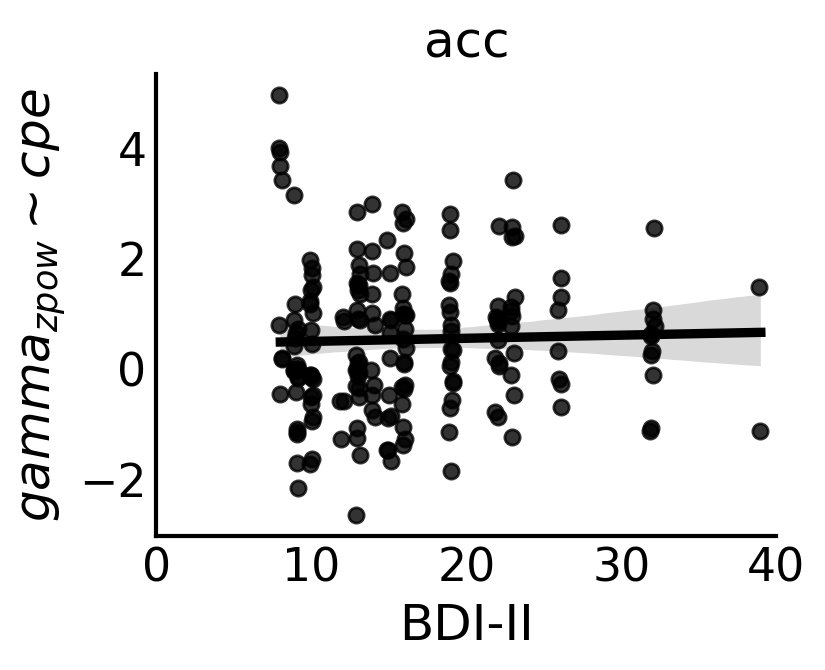

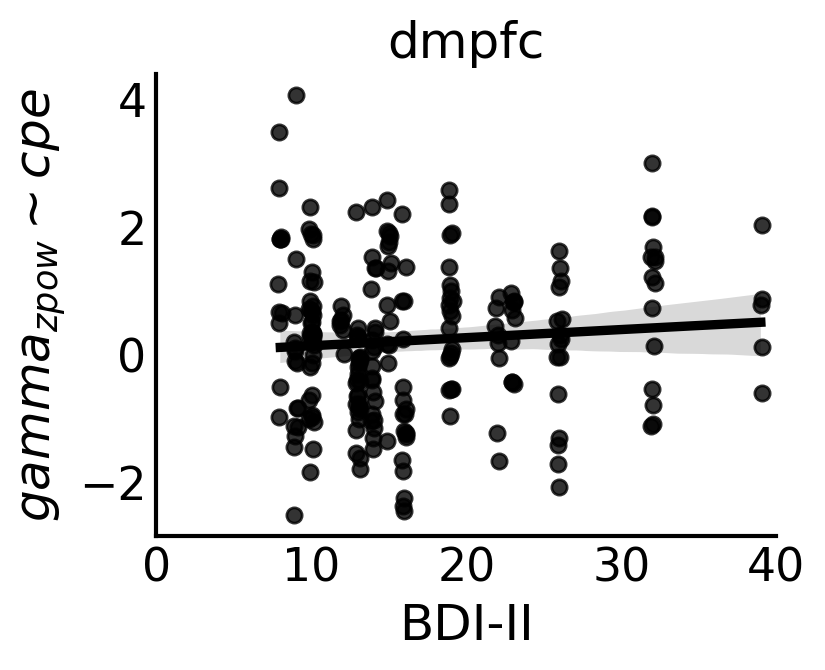

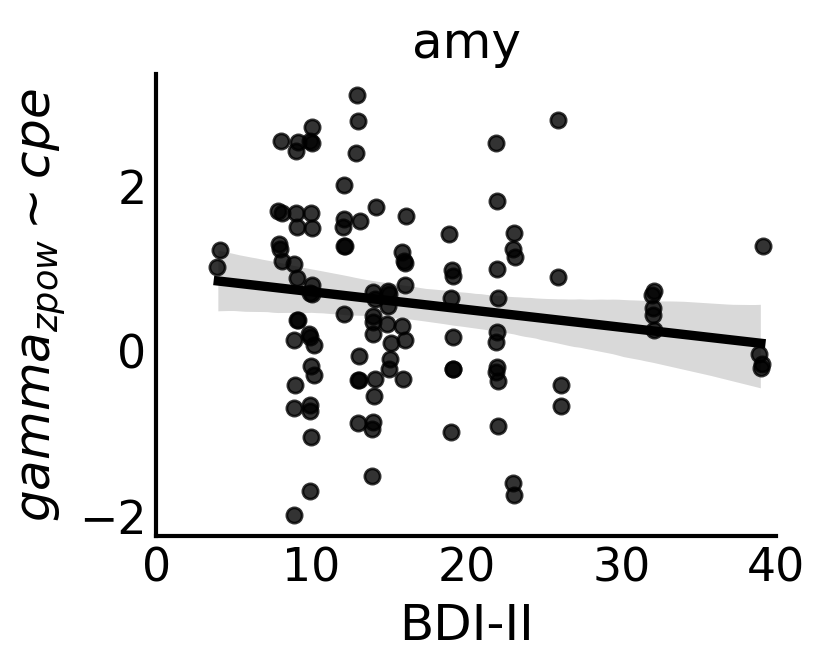

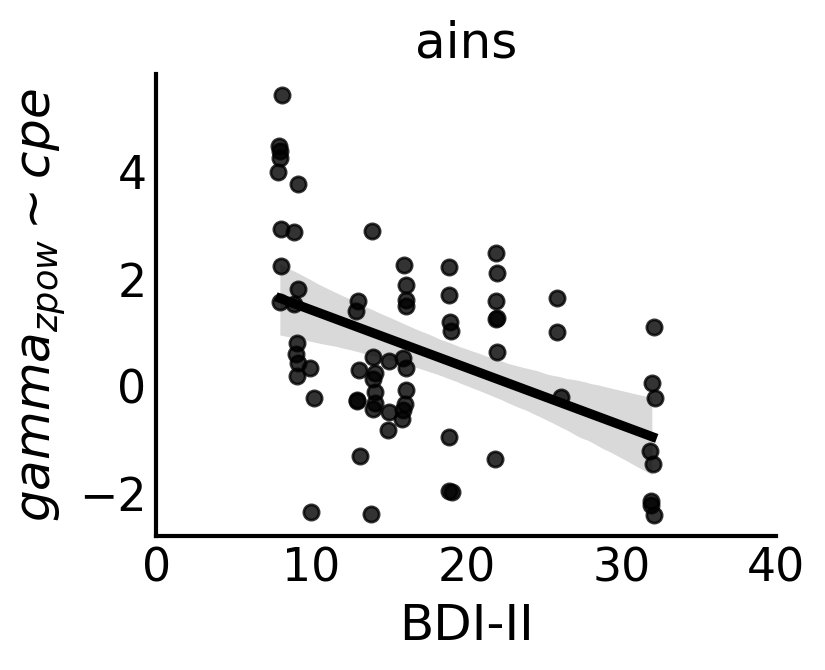

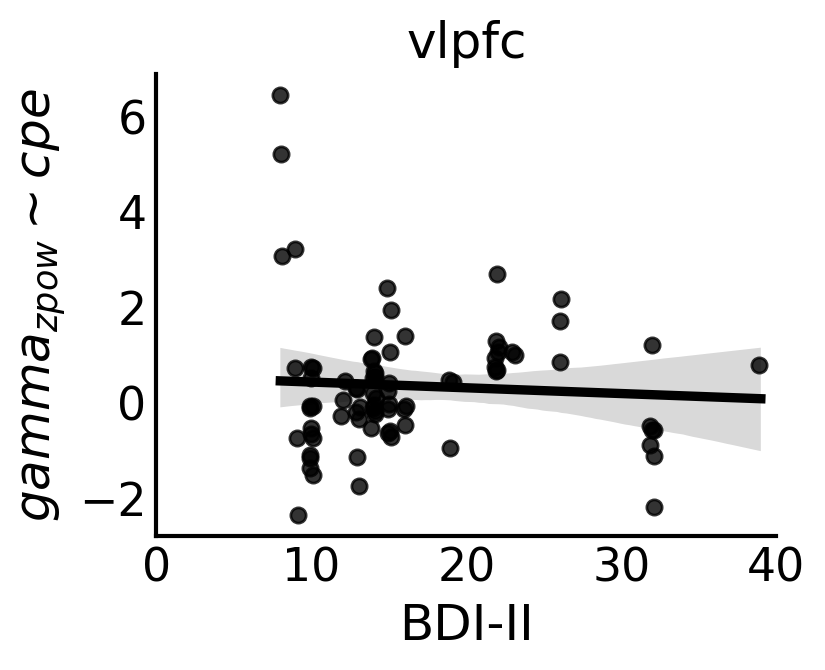

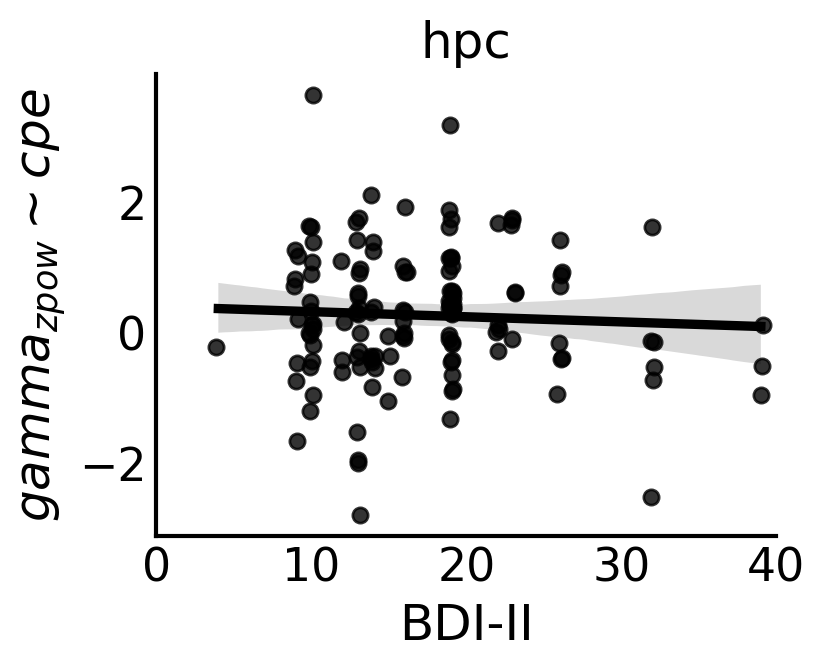

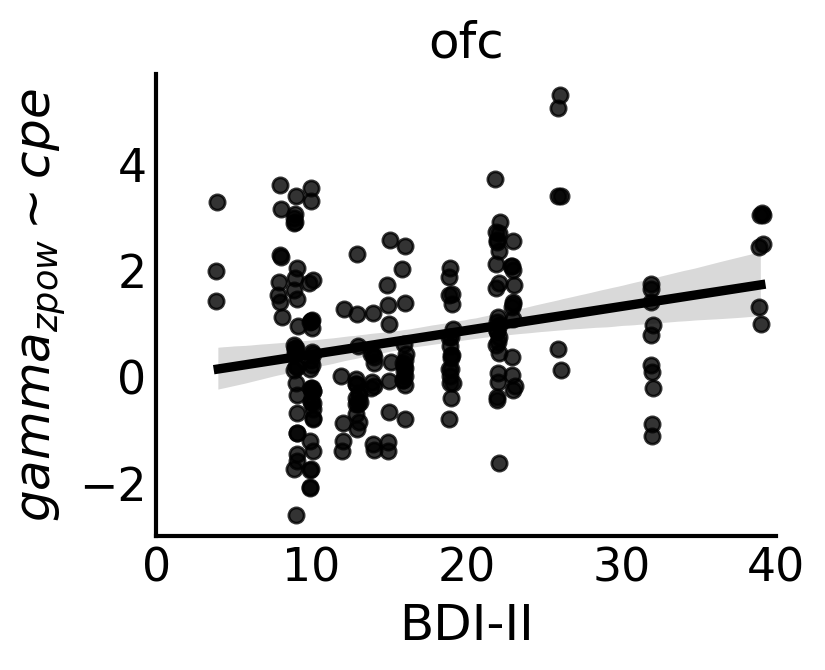

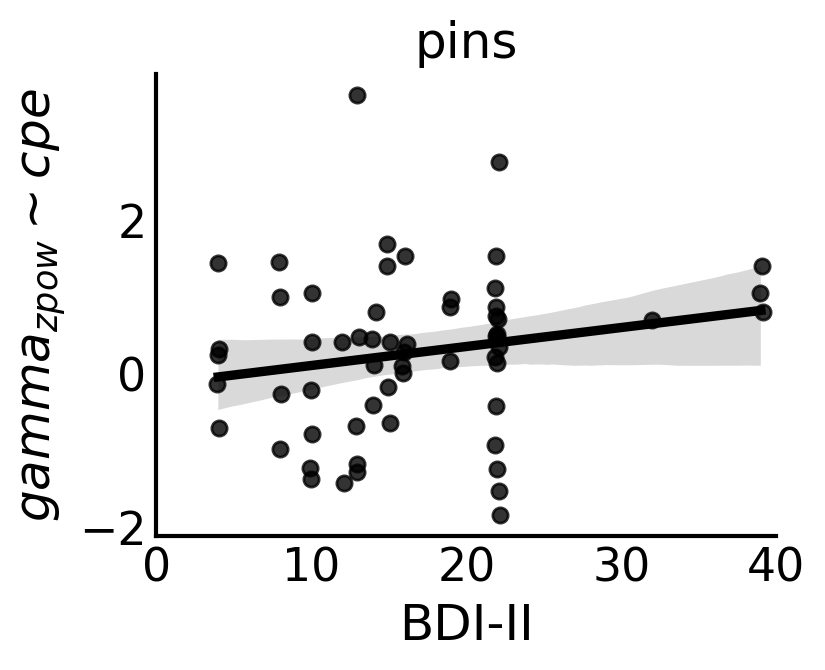

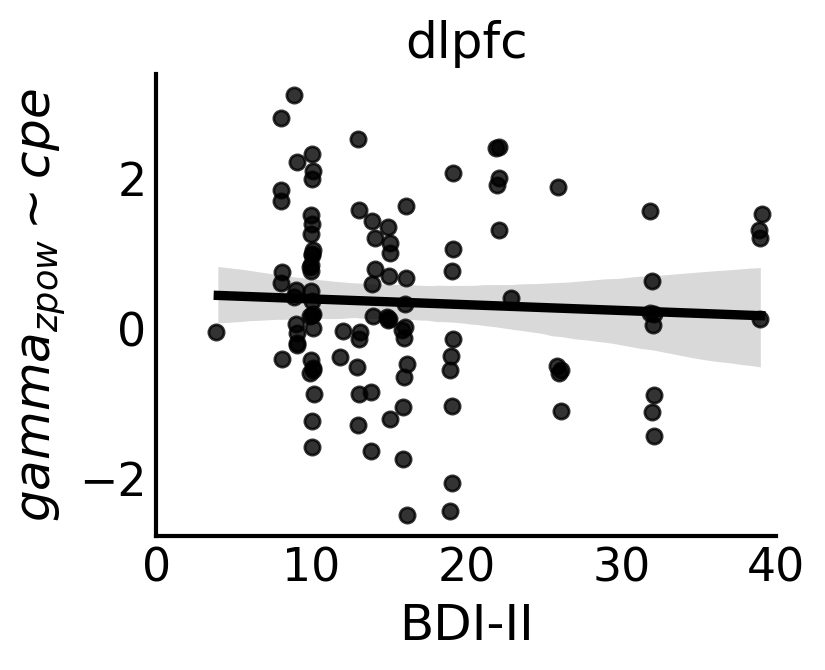

In [30]:
sns.set_context("talk",rc={'axes.linewidth': 1.5})

for roi in single_elec_res.roi.unique().tolist():
    
    roi_temp_data = single_elec_res[single_elec_res.roi==roi]
    
    corr_fig_id = f'{band}_{roi}_bdi_cpe_coeff_scatter_{epoch_len}.pdf'
        
    fig,ax = plt.subplots(1,1,figsize=(4,3),dpi=200)

    sns.regplot(data=roi_temp_data,x='bdi',y='Z_Score_cpe',scatter=True,ci=95,
                fit_reg=True,color = 'k',x_jitter = 0.15,scatter_kws={'s':30}) #034975

    
    plt.xlabel('BDI-II')
    plt.xlim([0,40])
    
    plt.tick_params(length=0) 
    plt.ylabel(fr'${band}_{{zpow}} \sim cpe$')


    plt.title(f'{roi}')
    sns.despine()
    
    
    plt.savefig(f'{fig_dir}{corr_fig_id}', format=corr_fig_id.split('.')[-1], metadata=None,
        bbox_inches='tight', pad_inches=0.1,dpi=400,
        facecolor='auto', edgecolor='auto',
        backend=None)


### Test BDI Correlations via robust regression

In [31]:
### robust regression bdi ~ cpe coefficients
roi_rlm_dict = {}

for roi in single_elec_res.roi.unique().tolist():
    roi_df = single_elec_res[single_elec_res.roi == roi]
    rlm = sm.RLM(roi_df.bdi.values, sm.add_constant(roi_df.Z_Score_cpe.values), M=sm.robust.norms.HuberT())
    rlm_results = rlm.fit()
    roi_rlm_dict[roi] = rlm_results
    print(roi)
    print(rlm_results.summary())




acc
                    Robust linear Model Regression Results                    
Dep. Variable:                      y   No. Observations:                  193
Model:                            RLM   Df Residuals:                      191
Method:                          IRLS   Df Model:                            1
Norm:                          HuberT                                         
Scale Est.:                       mad                                         
Cov Type:                          H1                                         
Date:                Wed, 25 Sep 2024                                         
Time:                        12:28:21                                         
No. Iterations:                    13                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
const         15.7803      0.476     33.140     

# Mixed effects models

In [58]:
from matplotlib.colors import ListedColormap,LinearSegmentedColormap
import matplotlib as mpl
# from matplotlib import cm


# # saez_cmap colors = org,yellow, sagegreen, darker green, blue, purple 

# # 671351
saez_colors    = ['#ffb243','#FCE27C','#6a9752','#1d5d2a','#00467e','#561C46']
saez_hex_cmap  = ListedColormap(saez_colors)
saez_rgb       = [mpl.colors.to_rgb(hex) for hex in saez_colors]
saez_full_cmap = LinearSegmentedColormap.from_list('saez_full_cmap',saez_rgb,N=10)
#plot_palette = saez_linear_cmap.resampled(lutsize=30)
expanded_cmap  = [mpl.colors.rgb2hex(saez_full_cmap(c)[:3]) for c in range(saez_full_cmap.N)]


In [62]:
expanded_cmap

['#ffb243',
 '#fdcd63',
 '#ecda77',
 '#9bb060',
 '#598a49',
 '#2e6a33',
 '#135546',
 '#034975',
 '#263365',
 '#561c46']

In [44]:
gamma_reg_df.columns

Index(['Unnamed: 0', 'subj_id', 'bdi', 'bdi_thresh', 'Round', 'RT',
       'TrialOnset', 'ChoiceOnset', 'DecisionOnset', 'FeedbackOnset',
       'ChoicePos', 'TrialType', 'SafeBet', 'LowBet', 'HighBet',
       'GambleChoice', 'Outcome', 'Profit', 'TotalProfit', 'epoch', 'logRT',
       'GambleEV', 'TrialEV', 'CR', 'choiceEV', 'rpe', 'res_type', 'cf',
       'max_cf', 'cpe', 'max_cpe', 'Round_t1', 'RT_t1', 'ChoicePos_t1',
       'TrialType_t1', 'SafeBet_t1', 'LowBet_t1', 'HighBet_t1',
       'GambleChoice_t1', 'Outcome_t1', 'Profit_t1', 'TotalProfit_t1',
       'epoch_t1', 'logRT_t1', 'GambleEV_t1', 'TrialEV_t1', 'CR_t1',
       'choiceEV_t1', 'rpe_t1', 'res_type_t1', 'cf_t1', 'max_cf_t1', 'cpe_t1',
       'max_cpe_t1', 'keep_epoch', 'keep_epoch_t1', 'CpeOnset',
       'reref_ch_names', 'band_pow', 'roi', 'hemi', 'unique_reref_ch'],
      dtype='object')

In [45]:
outcome_var  = 'band_pow'
rand_eff_var = 'unique_reref_ch'
reg_vars     = ['GambleChoice','TotalProfit', 'cpe']
rand_vars    = ['GambleChoice','TotalProfit', 'cpe']


In [46]:
roi_fit_dict = {f'{roi}':fit_mixed_model(gamma_reg_df[gamma_reg_df.roi==roi],
                                        reg_vars,rand_vars,outcome_var,rand_eff_var) 
                for roi in gamma_reg_df.roi.unique().tolist()}

roi_fit_results = []

for roi in list(roi_fit_dict.keys()):
    roi_fit = mixed_eff_results_df(roi_fit_dict[roi],gamma_reg_df[gamma_reg_df.roi==roi])
    roi_fit_results.append(roi_fit)
    
roi_fit_results = pd.concat(roi_fit_results).reset_index(drop=True)
roi_fit_results['band'] = 'gamma'
roi_fit_results.to_csv(f'{save_dir}{band}_mlm_roi_fit_results_{epoch_len}_{date}.csv')

In [47]:
roi_fit_results

,unique_reref_ch,subj_id,region_type,bdi,raw_Intercept,raw_GambleChoice[T.safe],raw_GambleChoice[T.skip],raw_TotalProfit,raw_cpe,Intercept,GambleChoice[T.safe],GambleChoice[T.skip],TotalProfit,cpe,band
0,DA023_lac1-lac2,DA023,acc,14,0.001974,0.016982,0.136149,-0.004391,-0.002996,0.003493,-0.002333,0.258109,-0.007942,0.011676,gamma
1,DA023_lac2-lac3,DA023,acc,14,0.001223,0.020290,0.184256,-0.008813,-0.018420,0.002742,0.000975,0.306216,-0.012364,-0.003748,gamma
2,DA023_lac3-lac4,DA023,acc,14,0.015145,0.017397,0.071274,0.017035,-0.018371,0.016664,-0.001918,0.193234,0.013484,-0.003699,gamma
3,MS002_lacas1-lacas2,MS002,acc,14,0.006736,-0.018742,-0.074997,-0.010648,0.017329,0.008255,-0.038056,0.046962,-0.014199,0.032001,gamma
4,MS002_lacas2-lacas3,MS002,acc,14,0.011682,-0.016309,-0.061840,-0.007405,0.009291,0.013201,-0.035623,0.060119,-0.010955,0.023964,gamma
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1183,MS050_rainss10-rainss11,MS050,dlpfc,9,0.004270,0.017961,0.034277,-0.009041,-0.005837,-0.005918,0.017892,0.258382,-0.012039,0.002432,gamma
1184,MS050_rainss11-rainss12,MS050,dlpfc,9,0.037067,-0.011332,-0.133634,0.017801,0.005903,0.026880,-0.011402,0.090472,0.014803,0.014172,gamma
1185,MS050_rainss6-rainss7,MS050,dlpfc,9,0.080399,0.085714,-0.086516,-0.011317,-0.024645,0.070211,0.085644,0.137589,-0.014314,-0.016376,gamma
1186,MS050_rainss7-rainss8,MS050,dlpfc,9,0.078906,0.060885,-0.110348,-0.002937,-0.021739,0.068718,0.060815,0.113757,-0.005934,-0.013470,gamma


In [48]:
# roi_fit_results

fe_params_results = {f'{roi}':roi_fit_dict[roi].fe_params for roi in list(roi_fit_dict.keys())}
fe_results = []
for fe_res in fe_params_results:
    fe_results.append(pd.DataFrame({**dict(fe_params_results[fe_res]),**{'roi':fe_res}},index=[0]))
    
fe_results = pd.concat(fe_results).reset_index(drop=True)
fe_results['cpe_pval'] = [np.round(roi_fit_dict[roi].pvalues['cpe'],4) for roi in fe_results.roi.tolist()]
# fe_results['bdi_pval'] = [np.round(roi_fit_dict[roi].pvalues['bdi'],4) for roi in fe_results.roi.tolist()]
# fe_results['cpe_bdi_pval'] = [np.round(roi_fit_dict[roi].pvalues['bdi:decisionCPE'],4) for roi in fe_results.roi.tolist()]

fe_results


,Intercept,GambleChoice[T.safe],GambleChoice[T.skip],TotalProfit,cpe,roi,cpe_pval
0,0.001519,-0.019314,0.121959,-0.003551,0.014672,acc,0.0000
1,-0.018237,0.004334,0.321362,-0.010098,0.005944,dmpfc,0.0088
2,-0.013059,-0.000234,-0.022155,-0.000582,0.015834,amy,0.0000
3,0.102935,-0.031035,0.198603,0.007864,0.028852,ains,0.0016
4,0.037422,-0.010662,0.141946,-0.009259,0.011709,vlpfc,0.0235
5,-0.019848,0.006439,0.107031,0.000134,0.007035,hpc,0.0034
6,0.005812,0.012252,-0.142425,-0.002005,0.020877,ofc,0.0000
7,-0.008760,0.000690,-0.000329,0.014653,0.006701,pins,0.0978
8,-0.010188,-0.000070,0.224105,-0.002997,0.008269,dlpfc,0.0200


In [49]:
fe_results.set_index('roi')

,Intercept,GambleChoice[T.safe],GambleChoice[T.skip],TotalProfit,cpe,cpe_pval
roi,,,,,,
acc,0.001519,-0.019314,0.121959,-0.003551,0.014672,0.0000
dmpfc,-0.018237,0.004334,0.321362,-0.010098,0.005944,0.0088
amy,-0.013059,-0.000234,-0.022155,-0.000582,0.015834,0.0000
ains,0.102935,-0.031035,0.198603,0.007864,0.028852,0.0016
vlpfc,0.037422,-0.010662,0.141946,-0.009259,0.011709,0.0235
hpc,-0.019848,0.006439,0.107031,0.000134,0.007035,0.0034
ofc,0.005812,0.012252,-0.142425,-0.002005,0.020877,0.0000
pins,-0.008760,0.000690,-0.000329,0.014653,0.006701,0.0978
dlpfc,-0.010188,-0.000070,0.224105,-0.002997,0.008269,0.0200


In [50]:
bonferr_alpha = 0.05/len(fe_results)
# bonferr_alpha = 0.01

bonferr_alpha



0.005555555555555556

In [51]:
sig_cpe_rois = fe_results.roi[fe_results.cpe_pval <= bonferr_alpha].tolist()
sig_cpe_rois



['acc', 'amy', 'ains', 'hpc', 'ofc']

In [52]:

raw_roi_stats = {f'{roi}':ttest_1samp(roi_fit_results.cpe[roi_fit_results.region_type == roi].unique(),
                 popmean=0) for roi in roi_fit_results.region_type.unique().tolist()}
raw_roi_stats



{'acc': TtestResult(statistic=12.154040214635772, pvalue=1.4025134814524954e-25, df=192),
 'dmpfc': TtestResult(statistic=10.160850570413642, pvalue=3.428278582949292e-20, df=224),
 'amy': TtestResult(statistic=17.65096811526053, pvalue=3.898103447058372e-34, df=112),
 'ains': TtestResult(statistic=4.026759430630154, pvalue=0.000141485348259277, df=70),
 'vlpfc': TtestResult(statistic=4.387821768244261, pvalue=3.4203298133730916e-05, df=81),
 'hpc': TtestResult(statistic=12.595021106680688, pvalue=1.7381589746202373e-24, df=134),
 'ofc': TtestResult(statistic=14.100568826329582, pvalue=7.629999929063844e-32, df=201),
 'pins': TtestResult(statistic=5.949485952112805, pvalue=1.56838417035135e-07, df=59),
 'dlpfc': TtestResult(statistic=5.577917804283426, pvalue=1.8774619481167544e-07, df=106)}

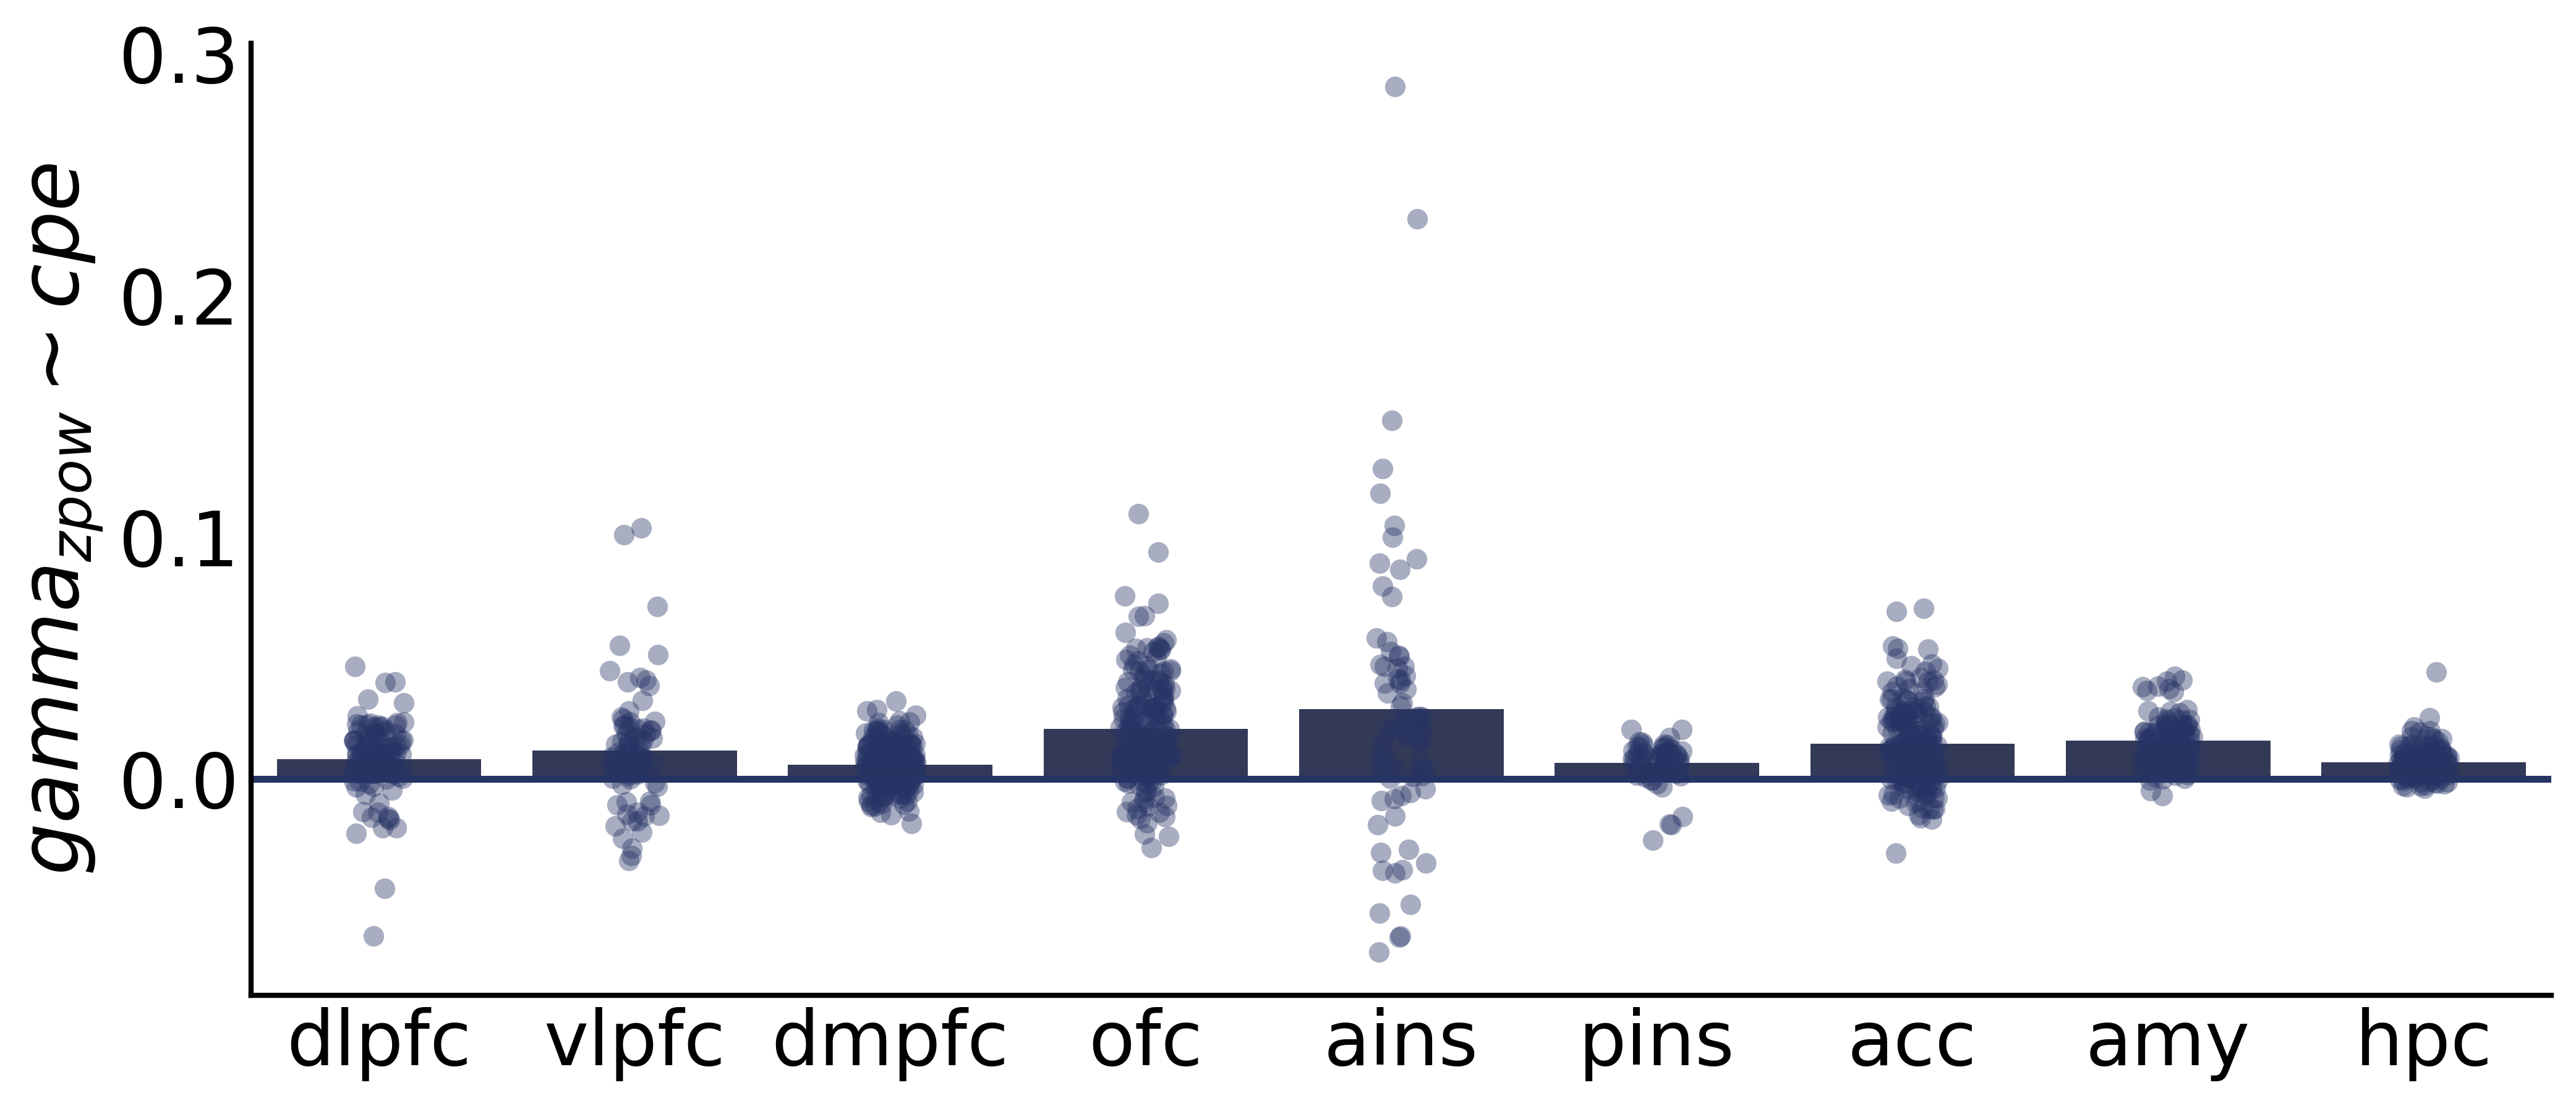

In [63]:
ylabel = fr'${band}_{{zpow}} \sim cpe$'
# fig_save_dir = '/sc/arion/projects/guLab/Alie/SWB/ephys_analysis/results/single-electrode-regressions/'
fig_id = f'{band}_mlm_roi_barplot_{epoch_len}.pdf'


plot_roi_model_results(roi_fit_results,'region_type','cpe',bar_order=bar_order,figsize=(12,5),color='#263365',
                       ylabel=ylabel,save_fig=True,save_dir=fig_dir,fig_id=fig_id,dpi=400)



# BDI Correlation

In [54]:
# CHECK BDI CORRELATION

rho_data = []
sig_rho = []

# BDI CORRELATIONS
for roi in roi_fit_results.region_type.unique().tolist():
    roi_temp_data = roi_fit_results[roi_fit_results.region_type==roi]
    rho,rho_p     = pearsonr(roi_temp_data.bdi,roi_temp_data.cpe)
#     rho,rho_p     = pearsonr(roi_temp_data.bdi,roi_temp_data.elec_bCPE)
#     print(f'{roi} pearsonr',rho,rho_p)
    rho_data.append(pd.DataFrame({'roi':roi,'rho':rho,'rho_p':rho_p},index=[0]))
#     if rho_p <= bonferr_alpha:
#         sig_bdi_rois.append(roi)
#     if rho_p < bonferr_alpha:
    if rho_p < 0.05:
        sig_rho.append((roi,rho,rho_p))
    print(f'{roi} pearsonr',rho,rho_p)
rho_data = pd.concat(rho_data).reset_index(drop=True)


acc pearsonr 0.022914239254060727 0.751768435225366
dmpfc pearsonr 0.09620654059999681 0.1503208930943268
amy pearsonr -0.01879715554846896 0.8433484385301445
ains pearsonr -0.4575268531330853 6.0347754934437504e-05
vlpfc pearsonr -0.08183292695112412 0.4648527159193805
hpc pearsonr 0.03448708559467079 0.6912968407398391
ofc pearsonr 0.17223944252457546 0.014240562309136786
pins pearsonr 0.1603480236040778 0.22100497649110212
dlpfc pearsonr 0.18336078062696137 0.05869349041639337


In [55]:
sig_rho

[('ains', -0.4575268531330853, 6.0347754934437504e-05),
 ('ofc', 0.17223944252457546, 0.014240562309136786)]

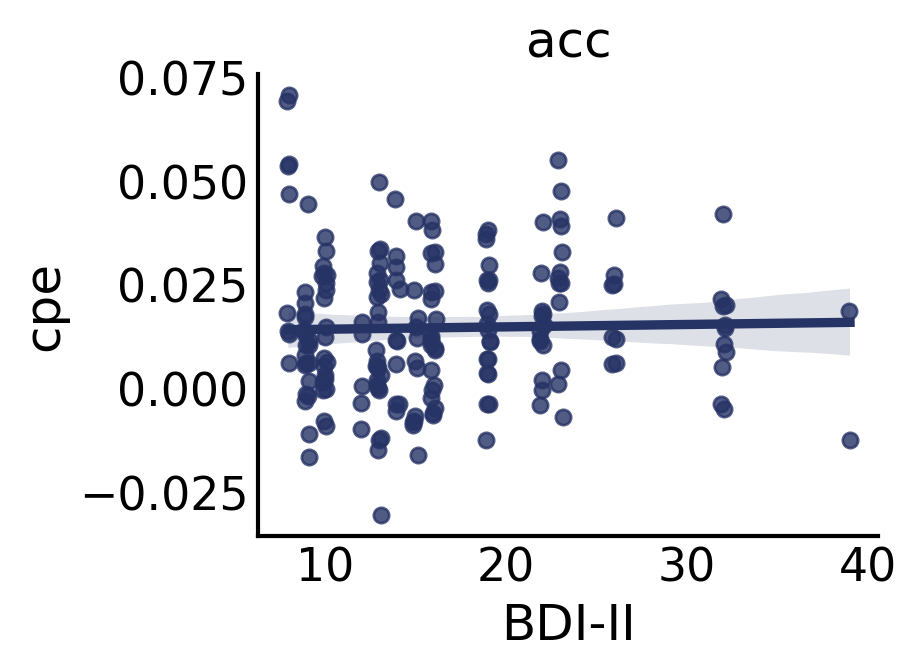

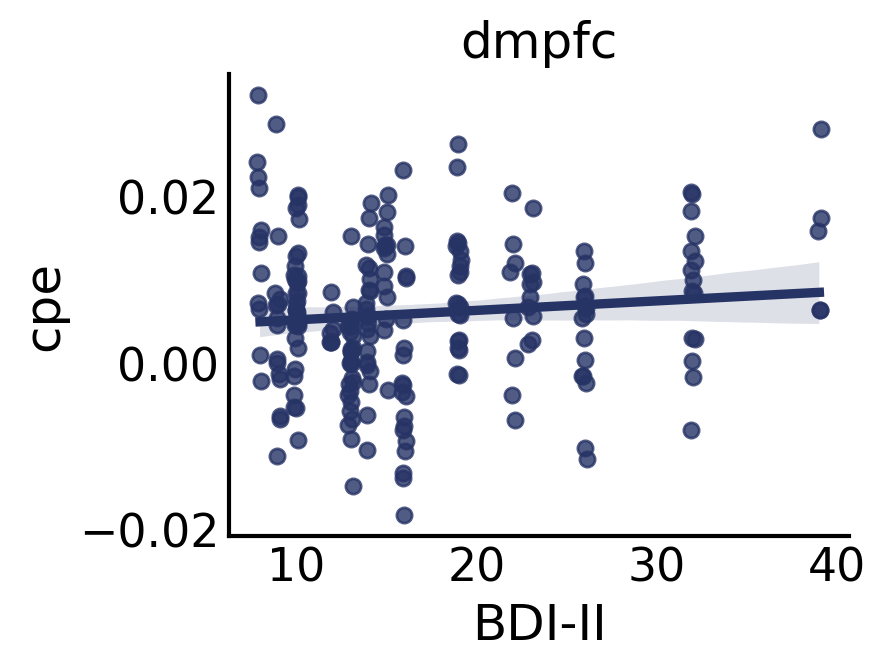

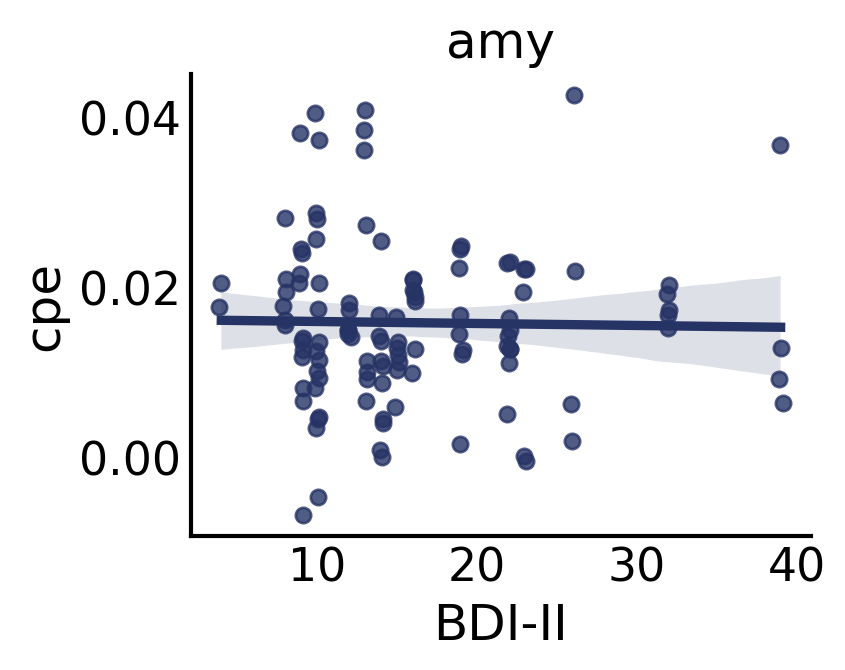

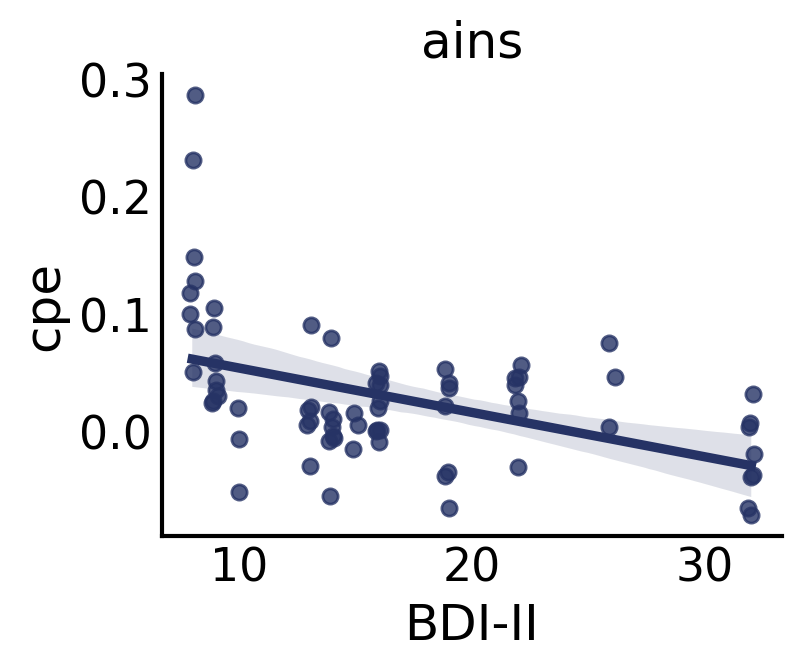

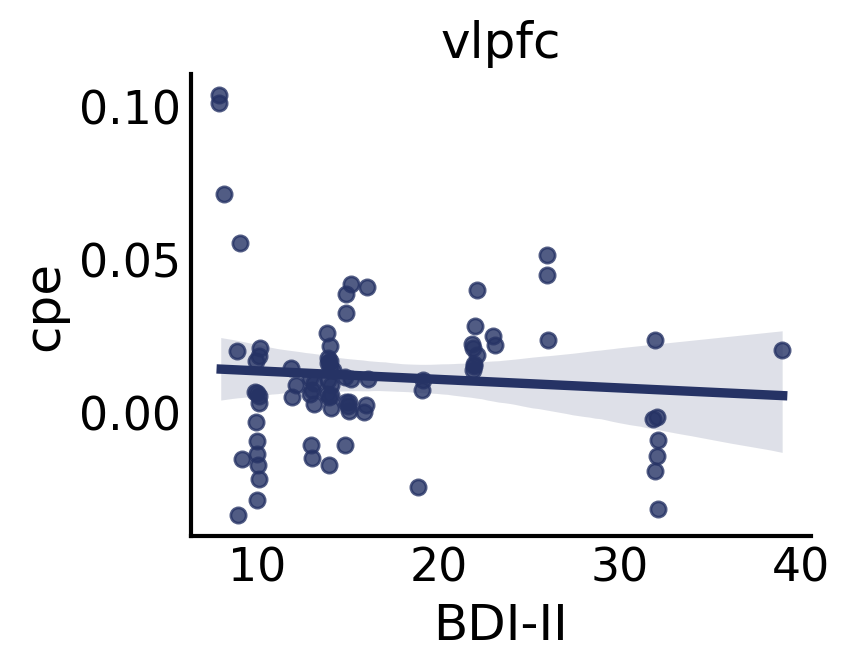

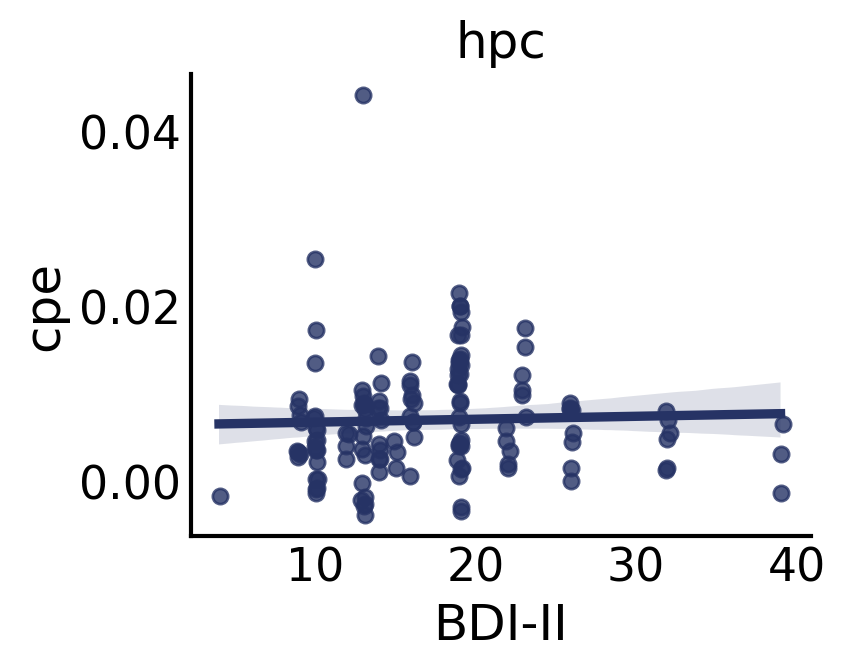

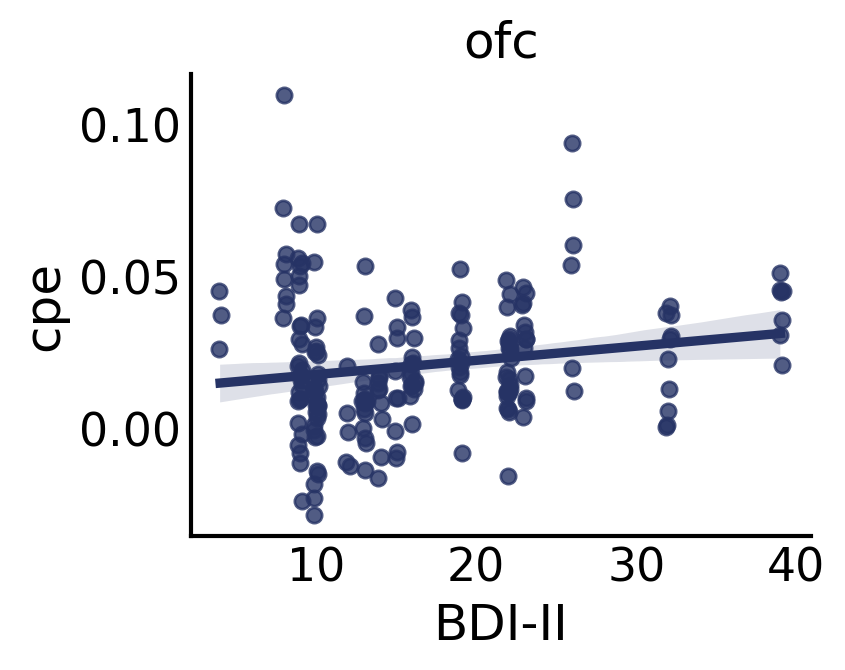

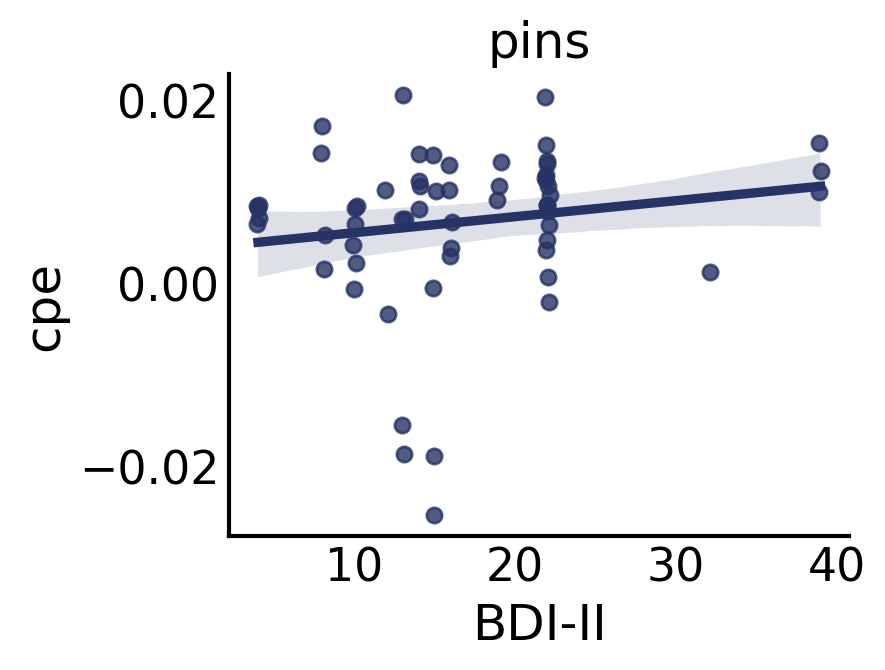

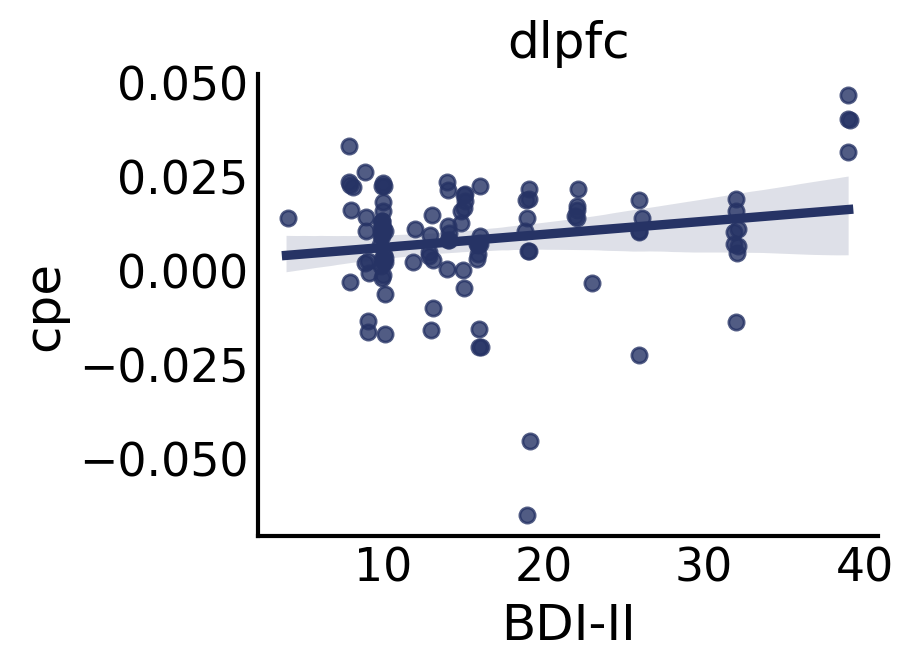

In [64]:

sns.set_context("talk",rc={'axes.linewidth': 1.5})

for roi in roi_fit_results.region_type.unique().tolist():
    
    roi_temp_data = roi_fit_results[roi_fit_results.region_type==roi]

#     rho   = rho_data[rho_data.roi == roi].round_rho.values[0]
#     rho_p = rho_data[rho_data.roi == roi].round_p.values[0]
    
        
    fig,ax = plt.subplots(1,1,figsize=(4,3),dpi=200)

    sns.regplot(data=roi_temp_data,x='bdi',y='cpe',scatter=True,ci=95,
                fit_reg=True,color = '#263365',x_jitter = 0.15,scatter_kws={'s':30}) #034975
    
#     sns.scatterplot(data = roi_temp_data.groupby(['subj_id']).agg('mean'),x='bdi',
#                     y='decisionCPE',color = '#00467e',edgecolor=None,alpha=0.8)
    
#     plt.gca().yaxis.set_major_formatter(StrMethodFormatter('{x:,.2f}')) 
    plt.xlabel('BDI-II')
#     plt.xlim([0,40])
    
    plt.tick_params(length=0) 
#     plt.ylabel('beta'+r'$beta_{{{zpow}}}$'+' cpe encoding')
#     plt.ylabel(fr'${band}_{{{zpow}}} \sim cpe$')

#     plt.text(np.max(roi_temp_data.bdi)-8,
#              np.round(np.max(roi_temp_data.groupby(['subj_id']).agg('mean').elec_bCPE),3)-0.003,
#              r'$rho$ = '+f'{rho} \n'+ fr'$p \approxeq $ {rho_p}',color='k',fontsize=12)
#              color='#00467e',fontsize=16)
#     plt.text(0.8,0.8,r'$rho$ = '+f'{rho} \n'+ fr'$p \approxeq $ {rho_p}',
#             verticalalignment='top', horizontalalignment='right',
#             color='k',fontsize=16)

    plt.title(f'{roi}')
    sns.despine()
#     plt.tight_layout()


    
#     sns.despine()
    
    plt.savefig(f'{fig_dir}/{roi}_{rho}_{rho_p}_roi_bdi_{band}-cpe-slope_{epoch_len}.pdf', format='pdf', metadata=None,
        bbox_inches='tight', pad_inches=0.1,dpi=300,
        facecolor='auto', edgecolor='auto',
        backend=None)
    

In [65]:
### robust regression bdi ~ cpe coefficients
roi_rlm_dict = {}

for roi in roi_fit_results.region_type.unique().tolist():
    roi_df = roi_fit_results[roi_fit_results.region_type == roi]
    rlm = sm.RLM(roi_df.bdi.values, sm.add_constant(roi_df.cpe.values), M=sm.robust.norms.HuberT())
    rlm_results = rlm.fit()
    roi_rlm_dict[roi] = rlm_results
    print(roi)
    print(rlm_results.summary())




acc
                    Robust linear Model Regression Results                    
Dep. Variable:                      y   No. Observations:                  193
Model:                            RLM   Df Residuals:                      191
Method:                          IRLS   Df Model:                            1
Norm:                          HuberT                                         
Scale Est.:                       mad                                         
Cov Type:                          H1                                         
Date:                Wed, 25 Sep 2024                                         
Time:                        01:30:01                                         
No. Iterations:                    13                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
const         15.6598      0.589     26.579     